<a href="https://colab.research.google.com/github/pedr0-almeida/AI2023/blob/main/tarefa_lixo_classificacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, BatchNormalization, ZeroPadding2D, MaxPool2D, Activation, add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import cv2
import numpy as np

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

import zipfile
import pandas as pd


from sklearn.metrics import classification_report, confusion_matrix

from keras.applications.mobilenet_v2 import MobileNetV2

In [ ]:
!gdown --id 1L4mdCDBgybKqr5Wo-kqT8HXcBJ9HXqSX

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1L4mdCDBgybKqr5Wo-kqT8HXcBJ9HXqSX
To: /content/trash_nov_22_2018.zip
100% 42.8M/42.8M [00:00<00:00, 79.0MB/s]


In [ ]:
FILE='trash_nov_22_2018.zip'

In [ ]:
archive = zipfile.ZipFile('trash_nov_22_2018.zip', 'r')
archive.extractall()

In [ ]:
img_name=[]
with zipfile.ZipFile(FILE, "r") as f:
    for name in f.namelist():
        img_name.append(name)

In [ ]:
Img_Size = 80
ref = 'jpg'
notref = 'met'

In [ ]:
X= []
Y =[]
n = len(img_name)
i = 0
for i in range(n):
  name = img_name[i]
  if(ref in name):
    Y.append(name)
    #X.append(cv2.imread(name,0))
    #img = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
    img = cv2.resize(cv2.imread(name), (224, 224))
    X.append(img)
m = len(Y)
X = np.array(X)
print(n,m)

2527 2527


In [ ]:
arrayX = np.array(X)
shapeX = arrayX.shape

In [ ]:
arrayY = np.array(Y)
shapeY = arrayY.shape

In [ ]:
nome = Y[0]

In [ ]:
lista =[]
for word in Y:
  lista.append(word[0:4])

In [ ]:
types = list(set(lista))

In [ ]:
types

['card', 'pape', 'plas', 'meta', 'glas', 'tras']

In [ ]:
y_data = []
for word in Y:
  if word[0:4] == types[0]:
    y_data.append(0)
  elif word[0:4] == types[1]:
    y_data.append(1)
  elif word[0:4] == types[2]:
    y_data.append(2)
  elif word[0:4] == types[3]:
    y_data.append(3)
  elif word[0:4] == types[4]:
    y_data.append(4)
  elif word[0:4] == types[5]:
    y_data.append(5)
  else:
    y_data.append(6)

In [ ]:
Y = y_data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [ ]:
X_train[0].shape

(224, 224, 3)

In [ ]:
df = pd.DataFrame({'class':y_train})
y_train = pd.get_dummies(df['class'])

In [ ]:
for i in range(6):
  df_plot= df[(df["class"] == i)]
  n= df_plot.shape[0]
  print(types[i],n)

card 332
pape 476
plas 383
meta 323
glas 394
tras 113


In [ ]:
df = pd.DataFrame({'class':y_test})
y_test = pd.get_dummies(df['class'])

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Criação do modelo
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(10,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compilação do modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
D = len(types)
base_learning_rate = 0.0005
optimizer_base = 'rms'
fine_tune_at = 20
epochs_base = 30

def model(base_learning_rate, epochs_base,optimizer_base, fine_tune_at = fine_tune_at ):

  model = MobileNetV2(weights='imagenet')
  model_output = Dense(D, activation= 'softmax') #'relu')
  model_output = model_output(model.layers[-2].output)
  model_input = model.input
  model_new = Model(inputs=model_input, outputs=model_output)

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in model.layers[:fine_tune_at]:
    layer.trainable = False

  if optimizer_base == 'adam':
    model_new.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
  elif optimizer_base == 'rms':
    model_new.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
  else:
    pass
  r = model_new.fit(
      x = X_train,
      y = y_train,
      validation_data=(X_test, y_test),
      epochs=epochs_base,
      verbose=2
  )
  return r

In [ ]:
r  = model(base_learning_rate, epochs_base, optimizer_base)

14536120/14536120 [==============================] - 0s 0us/step
Epoch 1/30
64/64 - 38s - loss: 1.2442 - accuracy: 0.5369 - val_loss: 1.8860 - val_accuracy: 0.3063 - 38s/epoch - 600ms/step
Epoch 2/30
64/64 - 6s - loss: 0.6492 - accuracy: 0.7887 - val_loss: 1.5798 - val_accuracy: 0.4249 - 6s/epoch - 89ms/step
Epoch 3/30
64/64 - 6s - loss: 0.3759 - accuracy: 0.8976 - val_loss: 1.5769 - val_accuracy: 0.4269 - 6s/epoch - 88ms/step
Epoch 4/30
64/64 - 6s - loss: 0.2344 - accuracy: 0.9510 - val_loss: 1.5962 - val_accuracy: 0.4111 - 6s/epoch - 87ms/step
Epoch 5/30
64/64 - 6s - loss: 0.1253 - accuracy: 0.9812 - val_loss: 1.7253 - val_accuracy: 0.4209 - 6s/epoch - 88ms/step
Epoch 6/30
64/64 - 6s - loss: 0.0756 - accuracy: 0.9916 - val_loss: 1.6171 - val_accuracy: 0.4644 - 6s/epoch - 89ms/step
Epoch 7/30
64/64 - 6s - loss: 0.0461 - accuracy: 0.9955 - val_loss: 1.4103 - val_accuracy: 0.4980 - 6s/epoch - 88ms/step
Epoch 8/30
64/64 - 6s - loss: 0.0297 - accuracy: 0.9960 - val_loss: 1.4736 - val_accu

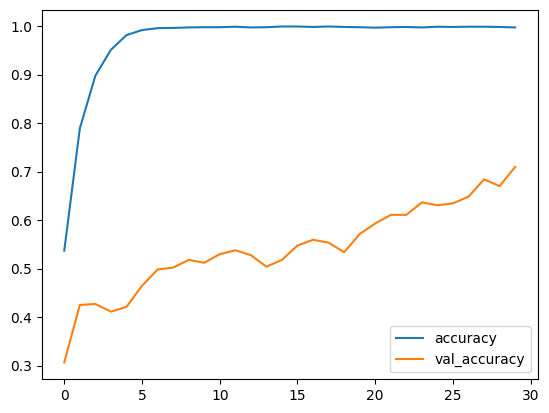

In [ ]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

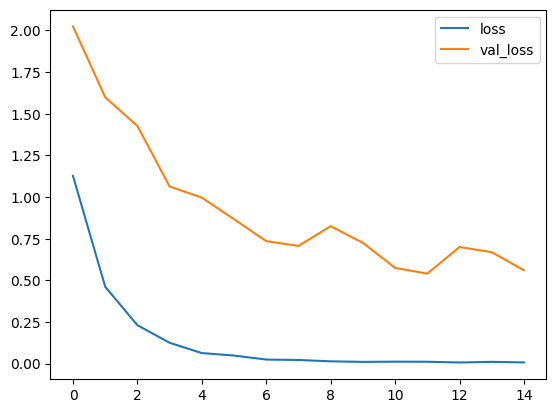

In [ ]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

In [ ]:
def retorna(y):
  resp = []
  for yi in y:
    vmax =max(yi)
    for idx, x in enumerate(yi):
      if(x == vmax):
        resp.append(idx)
  return resp

In [ ]:
test_loss, test_acc = model_new.evaluate(X_test,  y_test, verbose = 2)

16/16 - 1s - loss: 0.5611 - accuracy: 0.8281 - 669ms/epoch - 42ms/step


In [ ]:
predict = model_new.predict(X_test)

16/16 [==============================] - 1s 33ms/step


In [ ]:
y_calc = retorna(predict)
y_test = retorna(np.array(y_test))

confusion_matrix(y_test, y_calc)

array([[ 60,   5,   2,   4,   0,   0],
       [  2, 109,   5,   2,   0,   0],
       [  0,   0,  92,   1,   6,   0],
       [  0,   2,   5,  79,   1,   0],
       [  0,   1,  25,  11,  69,   1],
       [  0,   2,   7,   5,   0,  10]])

In [ ]:
#Classification Report
print('\n\n', classification_report(y_test, y_calc, target_names = types))



               precision    recall  f1-score   support

        card       0.97      0.85      0.90        71
        pape       0.92      0.92      0.92       118
        plas       0.68      0.93      0.78        99
        meta       0.77      0.91      0.84        87
        glas       0.91      0.64      0.75       107
        tras       0.91      0.42      0.57        24

    accuracy                           0.83       506
   macro avg       0.86      0.78      0.79       506
weighted avg       0.85      0.83      0.82       506



16/16 [==============================] - 1s 37ms/step


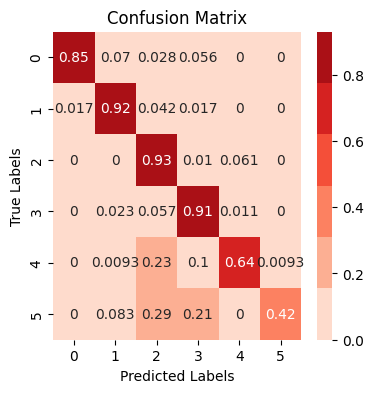

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Obtenha as previsões do modelo
y_pred = model_new.predict(X_test)
y_pred_types = np.argmax(y_pred, axis=1)

# Crie a matriz de confusão
cm = confusion_matrix(y_test, y_pred_types)

# Normalize a matriz de confusão
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Crie o mapa de cores para a matriz de confusão
cmap = sns.color_palette("Reds")

# Plote a matriz de confusão
plt.figure(figsize=(4, 4))
sns.heatmap(cm_normalized, annot=True, cmap=cmap)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()